In [1]:
pip install pandas openpyxl ccxt numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 33.3 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving BTC_spot_ETF_data_20250627.xlsx to BTC_spot_ETF_data_20250627.xlsx


In [3]:
import pandas as pd
import ccxt
import numpy as np
import traceback
import io # Required for reading uploaded file data
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration Parameters ---
INITIAL_CAPITAL = 100000.0
POSITION_INVESTMENT_AMOUNT = INITIAL_CAPITAL * 0.25
TRANSACTION_COST_PCT = 0.001

ETF_DATA_FILE_PATH = 'BTC_spot_ETF_data_20250618.xlsx' # IMPORTANT: Update this path
BTC_SYMBOL = 'BTC/USD'
EXCHANGE_NAME = 'coinbase'

In [4]:
# --- 1. Data Loading and Preparation (Functions remain mostly the same) ---
# --- Data Loading and Preparation Functions ---

# MODIFIED to accept either a file path or in-memory data
def load_etf_data(file_source):
    try:
        # The 'file_source' can now be a path (from tkinter) or bytes (from Colab upload)
        df = pd.read_excel(file_source)
        if 'Date' not in df.columns or 'NetInflow' not in df.columns:
            raise ValueError("Excel file must contain 'Date' and 'NetInflow' columns.")
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        df = df.resample('D').sum()
        return df
    except FileNotFoundError:
        print(f"Error: ETF data file not found.")
        return None
    except Exception as e:
        print(f"Error loading ETF data: {e}")
        return None
def fetch_btc_price_data(symbol, exchange_name, start_date_str):
    exchange = getattr(ccxt, exchange_name)()
    if not exchange.has['fetchOHLCV']:
        return None
    try:
        since = exchange.parse8601(start_date_str + 'T00:00:00Z')
        limit = 2000
        ohlcv = exchange.fetch_ohlcv(symbol, '1d', since, limit=limit)
        if not ohlcv:
            return None
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
        df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('Date', inplace=True)
        return df[['Open', 'High', 'Low', 'Close', 'Volume']]
    except Exception as e:
        print(f"An unexpected error occurred in fetch_btc_price_data: {e}")
        traceback.print_exc()
        return None

def align_data(etf_df, btc_df):
    if etf_df is None or btc_df is None:
        return None
    if etf_df.index.tz is not None: etf_df.index = etf_df.index.tz_localize(None)
    if btc_df.index.tz is not None: btc_df.index = btc_df.index.tz_localize(None)
    combined_df = pd.merge(btc_df, etf_df, left_index=True, right_index=True, how='inner')
    combined_df['NetInflow_shifted'] = combined_df['NetInflow'].shift(1)
    combined_df.dropna(subset=['NetInflow_shifted'], inplace=True)
    return combined_df

In [5]:
# --- 2. NEW: Asymmetric Signal Generation ---

def generate_signals(df, entry_ma_window, exit_ma_window):
    """
    Generates signals using different moving average windows for entry and exit.
    - entry_ma_window: The MA window for the buy signal threshold.
    - exit_ma_window: The MA window for the sell signal threshold.
    """
    df_signal = df.copy()

    # Calculate two different moving averages
    df_signal['EntryThreshold_MA'] = df_signal['NetInflow_shifted'].rolling(window=entry_ma_window).mean()
    df_signal['ExitThreshold_MA'] = df_signal['NetInflow_shifted'].rolling(window=exit_ma_window).mean()

    # Drop rows where the longer of the two MAs is not yet available
    df_signal.dropna(subset=['EntryThreshold_MA', 'ExitThreshold_MA'], inplace=True)

    df_signal['Signal'] = 0

    # Buy Signal: Inflow crosses ABOVE the shorter-term entry MA.
    buy_condition = (df_signal['NetInflow_shifted'] > df_signal['EntryThreshold_MA'])
    df_signal.loc[buy_condition, 'Signal'] = 1

    # Sell Signal: Inflow crosses BELOW the longer-term exit MA.
    sell_condition = (df_signal['NetInflow_shifted'] < df_signal['ExitThreshold_MA'])
    df_signal.loc[sell_condition, 'Signal'] = -1

    return df_signal

In [11]:
# --- 3. NEW: Backtesting Engine without Stop-Loss ---

def run_backtest(df, initial_capital, position_investment, transaction_cost_pct):
    cash = initial_capital
    btc_held = 0.0
    position_open = False
    entry_price = 0.0
    portfolio_values = []

    # NEW: Trade statistics
    num_trades = 0
    num_wins = 0

    for i in range(len(df)):
        date = df.index[i]
        today_open = df['Open'].iloc[i]
        today_close = df['Close'].iloc[i]
        signal = df['Signal'].iloc[i]

        if not position_open and signal == 1:
            if cash >= position_investment:
                buy_price = today_open
                btc_to_acquire = position_investment / buy_price
                fee = position_investment * transaction_cost_pct
                cash -= (position_investment + fee)
                btc_held = btc_to_acquire
                position_open = True
                entry_price = buy_price # Store entry price for win rate calculation

        elif position_open and signal == -1:
            sell_price = today_open
            proceeds = btc_held * sell_price
            fee = proceeds * transaction_cost_pct
            cash += (proceeds - fee)
            btc_held = 0.0
            position_open = False

            # NEW: Record trade outcome
            num_trades += 1
            if sell_price > entry_price:
                num_wins += 1
            entry_price = 0.0 # Reset entry price

        current_portfolio_value = cash + (btc_held * today_close)
        portfolio_values.append({'Date': date, 'PortfolioValue': current_portfolio_value})

    portfolio_df = pd.DataFrame(portfolio_values).set_index('Date') if portfolio_values else None

    # Return a dictionary with all results
    return {
        'portfolio_df': portfolio_df,
        'num_trades': num_trades,
        'num_wins': num_wins
    }

In [7]:
# --- 4. Performance Calculation (remains the same) ---

def calculate_performance_metrics(portfolio_df, initial_capital):
    if portfolio_df is None or portfolio_df.empty or len(portfolio_df) < 2:
        return {'Sharpe Ratio': -99, 'Total Return (%)': -100, 'Max Drawdown (%)': -100}

    metrics = {}
    final_value = portfolio_df['PortfolioValue'].iloc[-1]
    metrics['Total Return (%)'] = ((final_value / initial_capital) - 1) * 100

    portfolio_df['Peak'] = portfolio_df['PortfolioValue'].cummax()
    portfolio_df['Drawdown'] = (portfolio_df['PortfolioValue'] - portfolio_df['Peak']) / portfolio_df['Peak']
    metrics['Max Drawdown (%)'] = portfolio_df['Drawdown'].min() * 100

    portfolio_df['Daily Return'] = portfolio_df['PortfolioValue'].pct_change()
    avg_daily_return = portfolio_df['Daily Return'].mean()
    std_daily_return = portfolio_df['Daily Return'].std()

    if std_daily_return != 0 and not np.isnan(std_daily_return):
        sharpe_ratio = (avg_daily_return / std_daily_return) * np.sqrt(252)
        metrics['Sharpe Ratio'] = sharpe_ratio
    else:
        metrics['Sharpe Ratio'] = 0.0

    return metrics

In [14]:
# --- MODIFIED Buy and Hold Benchmark Calculation ---
def calculate_buy_and_hold_performance(df, initial_capital, transaction_cost_pct):
    if df is None or df.empty:
        return None

    buy_price = df['Open'].iloc[0]
    final_price = df['Close'].iloc[-1]
    fee = initial_capital * transaction_cost_pct
    amount_to_invest = initial_capital - fee
    btc_bought = amount_to_invest / buy_price

    portfolio_df = pd.DataFrame(index=df.index)
    portfolio_df['PortfolioValue'] = btc_bought * df['Close']

    # B&H is one trade. It's a win if the final price is > buy price.
    num_trades = 1
    num_wins = 1 if final_price > buy_price else 0

    return {
        'portfolio_df': portfolio_df,
        'num_trades': num_trades,
        'num_wins': num_wins
    }

Running in a Colab environment. Please upload your file.


Saving BTC_spot_ETF_data_20250627.xlsx to BTC_spot_ETF_data_20250627 (4).xlsx
User uploaded file "BTC_spot_ETF_data_20250627 (4).xlsx"

Loading data...

--- Calculating Buy & Hold Benchmark Performance ---
Benchmark Metrics Calculated.

--- Starting Asymmetric Strategy Optimization ---
Testing with Entry MA: 3, Exit MA: 10
--> Sharpe: 1.63, Return: 13.80%, Trades: 47, Win Rate: 68.1%
Testing with Entry MA: 3, Exit MA: 12
--> Sharpe: 1.57, Return: 12.70%, Trades: 44, Win Rate: 61.4%
Testing with Entry MA: 3, Exit MA: 14
--> Sharpe: 2.10, Return: 17.12%, Trades: 41, Win Rate: 68.3%
Testing with Entry MA: 3, Exit MA: 16
--> Sharpe: 1.76, Return: 14.47%, Trades: 36, Win Rate: 58.3%
Testing with Entry MA: 3, Exit MA: 18
--> Sharpe: 1.64, Return: 13.42%, Trades: 36, Win Rate: 58.3%
Testing with Entry MA: 3, Exit MA: 20
--> Sharpe: 1.76, Return: 13.87%, Trades: 36, Win Rate: 58.3%
Testing with Entry MA: 3, Exit MA: 22
--> Sharpe: 1.77, Return: 14.10%, Trades: 35, Win Rate: 68.6%
Testing with 

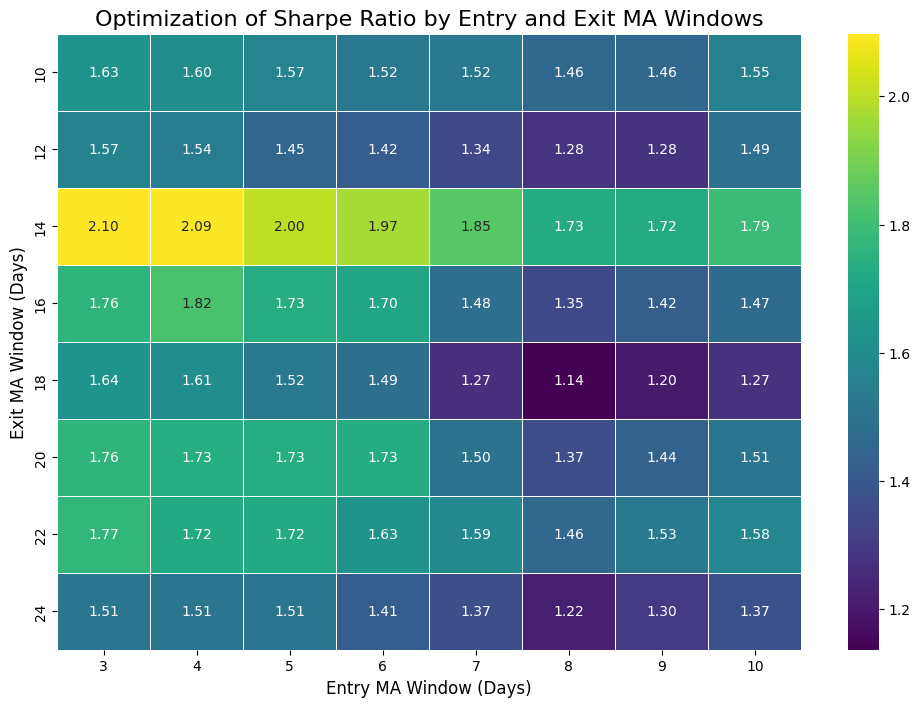

In [15]:
# --- Main Execution Block ---
if __name__ == '__main__':
    file_source = None
    try:
        from google.colab import files
        print("Running in a Colab environment. Please upload your file.")
        uploaded = files.upload()
        if uploaded:
            filename = next(iter(uploaded))
            print(f'User uploaded file "{filename}"')
            file_source = io.BytesIO(uploaded[filename])
        else:
            print("No file was uploaded."); exit()
    except (ImportError, ModuleNotFoundError):
        print("Not in Colab. This script is designed for Google Colab. Exiting."); exit()

    print("\nLoading data...")
    etf_df = load_etf_data(file_source)
    if etf_df is None: exit()

    start_date_btc = etf_df.index.min().strftime('%Y-%m-%d')
    btc_df = fetch_btc_price_data(BTC_SYMBOL, EXCHANGE_NAME, start_date_btc)
    if btc_df is None: exit()

    base_data = align_data(etf_df, btc_df)
    if base_data is None or base_data.empty:
        print("Could not align data. Exiting."); exit()

    print("\n--- Calculating Buy & Hold Benchmark Performance ---")
    benchmark_results = calculate_buy_and_hold_performance(base_data, INITIAL_CAPITAL, TRANSACTION_COST_PCT)
    benchmark_metrics = calculate_performance_metrics(benchmark_results['portfolio_df'], INITIAL_CAPITAL)
    print("Benchmark Metrics Calculated.")

    entry_ma_options = range(3, 11)
    exit_ma_options = range(10, 26, 2)
    optimization_results = []

    print("\n--- Starting Asymmetric Strategy Optimization ---")
    for entry_days in entry_ma_options:
        for exit_days in exit_ma_options:
            if exit_days < entry_days: continue
            print(f"Testing with Entry MA: {entry_days}, Exit MA: {exit_days}")
            df_with_signals = generate_signals(base_data, entry_ma_window=entry_days, exit_ma_window=exit_days)
            if df_with_signals.empty: continue

            backtest_results = run_backtest(df_with_signals, INITIAL_CAPITAL, POSITION_INVESTMENT_AMOUNT, TRANSACTION_COST_PCT)
            portfolio_history = backtest_results['portfolio_df']
            num_trades = backtest_results['num_trades']
            num_wins = backtest_results['num_wins']

            if portfolio_history is not None:
                metrics = calculate_performance_metrics(portfolio_history, INITIAL_CAPITAL)
                win_rate = (num_wins / num_trades) * 100 if num_trades > 0 else 0

                result_entry = {
                    'Entry MA': entry_days,
                    'Exit MA': exit_days,
                    'Sharpe Ratio': metrics['Sharpe Ratio'],
                    'Total Return (%)': metrics['Total Return (%)'],
                    'Max Drawdown (%)': metrics['Max Drawdown (%)'],
                    'Num Trades': num_trades,
                    'Win Rate (%)': win_rate
                }
                optimization_results.append(result_entry)
                print(f"--> Sharpe: {metrics['Sharpe Ratio']:.2f}, Return: {metrics['Total Return (%)']:.2f}%, Trades: {num_trades}, Win Rate: {win_rate:.1f}%")

    if optimization_results:
        results_df = pd.DataFrame(optimization_results)
        print("\n\n--- OPTIMIZATION COMPLETE ---")
        print("Results sorted by Sharpe Ratio (descending):")
        results_df_sorted = results_df.sort_values(by='Sharpe Ratio', ascending=False)
        # Format the win rate for cleaner display in the final table
        results_df_sorted['Win Rate (%)'] = results_df_sorted['Win Rate (%)'].map('{:.1f}'.format)
        print(results_df_sorted.to_string(index=False))

        best_params_row = results_df_sorted.iloc[0]

        # MODIFIED Comparison Table
        benchmark_win_rate = (benchmark_results['num_wins'] / benchmark_results['num_trades']) * 100 if benchmark_results['num_trades'] > 0 else 0
        comparison_data = {
            'Metric': ['Sharpe Ratio', 'Total Return (%)', 'Max Drawdown (%)', 'Num Trades', 'Win Rate (%)'],
            'Best Strategy': [
                float(best_params_row['Sharpe Ratio']),
                float(best_params_row['Total Return (%)']),
                float(best_params_row['Max Drawdown (%)']),
                int(best_params_row['Num Trades']),
                float(best_params_row['Win Rate (%)'])
            ],
            'Buy & Hold': [
                benchmark_metrics['Sharpe Ratio'],
                benchmark_metrics['Total Return (%)'],
                benchmark_metrics['Max Drawdown (%)'],
                benchmark_results['num_trades'],
                benchmark_win_rate
            ]
        }
        comparison_df = pd.DataFrame(comparison_data)

        print("\n\n--- Best Strategy vs. Buy & Hold Benchmark ---")
        print(f"Best Parameters: Entry MA = {int(best_params_row['Entry MA'])}, Exit MA = {int(best_params_row['Exit MA'])}")
        # Format the output for better readability
        comparison_df['Best Strategy'] = comparison_df['Best Strategy'].map('{:.2f}'.format)
        comparison_df['Buy & Hold'] = comparison_df['Buy & Hold'].map('{:.2f}'.format)
        print(comparison_df.to_string(index=False))

        print("\n--- Generating Optimization Heatmap ---")
        heatmap_data = results_df.pivot(index='Exit MA', columns='Entry MA', values='Sharpe Ratio')
        plt.figure(figsize=(12, 8))
        sns.heatmap(heatmap_data.astype(float), annot=True, fmt=".2f", cmap='viridis', linewidths=.5)
        plt.title('Optimization of Sharpe Ratio by Entry and Exit MA Windows', fontsize=16)
        plt.xlabel('Entry MA Window (Days)', fontsize=12)
        plt.ylabel('Exit MA Window (Days)', fontsize=12)
        plt.show()

    else:
        print("\nOptimization did not yield any results.")

